<a href="https://colab.research.google.com/github/parthava-adabala/learning/blob/main/03_Pytorch_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__

('2.8.0+cu126', '0.23.0+cu126')

# Get dataset

In [2]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(), target_transform=None)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
targets = train_data.targets
targets

tensor([9, 0, 0,  ..., 3, 0, 5])

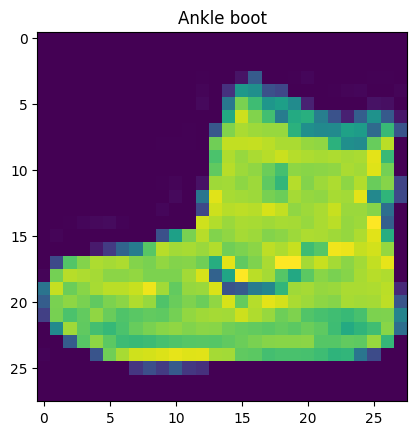

In [9]:
plt.imshow(image.squeeze())
plt.title(classes[label])
plt.show()

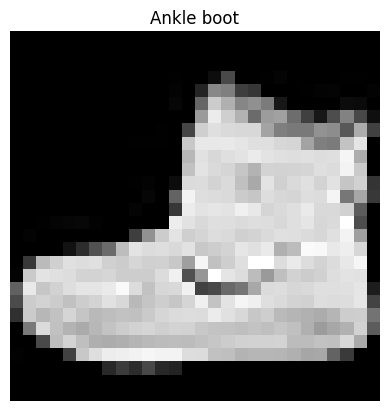

In [10]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(classes[label])
plt.axis('off')
plt.show()

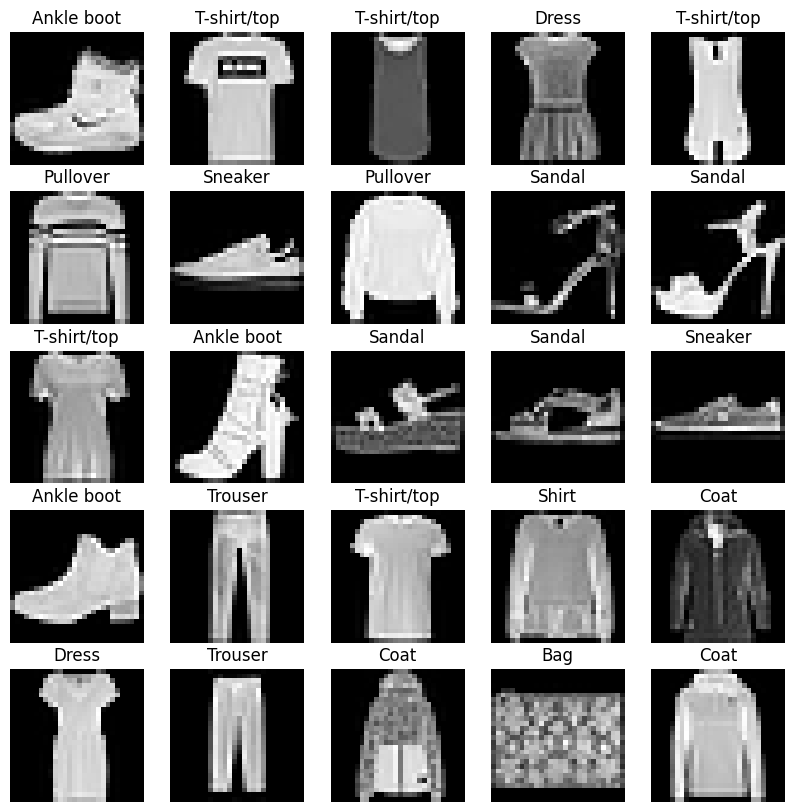

In [11]:
# Let's plot more images

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    image, label = train_data[i]
    plt.imshow(image.squeeze(), cmap='gray', aspect='auto')
    plt.title(classes[label])
    plt.axis('off')
plt.show()

#prepare data loader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78bcb1d8bb30>,
 <torch.utils.data.dataloader.DataLoader at 0x78bcb111c770>)

In [13]:
train_dataloader.batch_size, len(train_dataloader)

(32, 1875)

In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

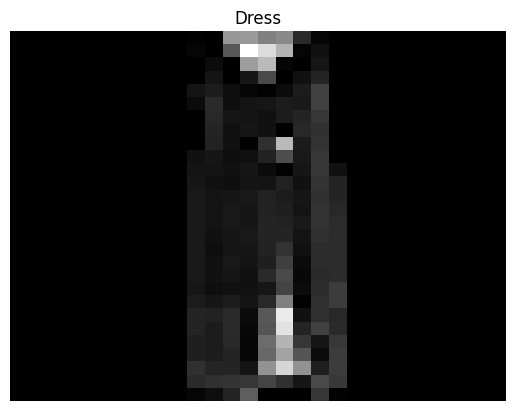

In [15]:
#sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap='gray', aspect='auto')
plt.title(classes[label])
plt.axis('off')
plt.show()

# Baseline model

In [16]:
# flatten layer
flatten = torch.nn.Flatten()
x = train_features_batch[0]
out = flatten(x)
x.shape, out.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [17]:
out.squeeze()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
        0.1647, 0.4588, 0.3843, 0.3686, 0.3686, 0.4824, 0.5176, 0.5137, 0.5569,
        0.4000, 0.0588, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3608,
        0.6431, 0.7451, 0.8078, 0.9255, 0.9529, 0.9765, 0.9490, 0.9961, 0.9059,
        0.9216, 0.8549, 0.7569, 0.7922, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.4902, 0.8235, 0.6863, 0.5882, 0.8745, 0.8549, 0.8627, 0.5882, 0.5647,
        0.9059, 0.7686, 0.7569, 0.6941, 0.8353, 0.0980, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3529, 0.8745, 0.7059, 0.6235, 0.6902, 0.9529, 0.9333, 0.4353,
        0.7529, 0.8314, 0.5529, 0.6745, 0.7490, 0.8000, 0.0118, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [18]:
class FashionMNISTV0(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [19]:
torch.manual_seed(42)
model_0 = FashionMNISTV0(input_shape=784, hidden_units=10, output_shape=len(classes))
model_0

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [21]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

In [22]:
# loss function and optimizer and eval metric
from helper_functions import accuracy_fn

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [23]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [24]:
start_time = timer()
#some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


2.9507999983025002e-05

In [25]:
# training loop
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
  train_loss /= len(train_dataloader)
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))
total_train_time_model_0

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.59039 | Test loss: 0.50954 | Test acc: 82.04%
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.47633 | Test loss: 0.47989 | Test acc: 83.20%
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.45503 | Test loss: 0.47664 | Test acc: 83.43%
Train time on cpu: 28.936 seconds


28.93595810100001

In [28]:
# Make preds
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" # Define device here
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device=device):
  loss, acc = 0, 0
  model.eval()
  model.to(device) # Move the model to the target device
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X).to(device) # Move prediction to the device
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV0',
 'model_loss': 0.4766389727592468,
 'model_acc': 83.42651757188499}

#device agnostic code

In [29]:
!nvidia-smi

Tue Oct 21 03:37:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             27W /   70W |     150MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
torch.cuda.is_available()

True

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
# Model 1 with non linearity
class FashionMNISTV1(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape),
            torch.nn.ReLU()
            )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [33]:
# create model instance
torch.manual_seed(42)
model_1 = FashionMNISTV1(input_shape=784, hidden_units=10, output_shape=len(classes)).to(device)

In [34]:
from helper_functions import accuracy_fn
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

# Functionizing train test loops

In [35]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"train_loss:{train_loss:.5f}, train_acc:{train_acc:.2f}%")

In [36]:
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test_loss:{test_loss:.5f}, test_acc:{test_acc:.2f}%")

In [37]:
torch.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device = device)
  test_step(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device = device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
train_loss:1.09199, train_acc:61.34%
test_loss:0.95636, test_acc:65.00%
Epoch: 1
-------
train_loss:0.78101, train_acc:71.93%
test_loss:0.72227, test_acc:73.91%
Epoch: 2
-------
train_loss:0.67027, train_acc:75.94%
test_loss:0.68500, test_acc:75.02%
Train time on cuda:0: 33.390 seconds


In [38]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

#Model 2 with CNN

In [39]:
class FashionMNISTV2(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=hidden_units*7*7, out_features=output_shape))

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [40]:
torch.manual_seed(42)
model_2 = FashionMNISTV2(input_shape=1, hidden_units=10, output_shape=len(classes)).to(device)
model_2

FashionMNISTV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# Stepping through nn.Conv2d

In [41]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
images.shape, test_image.shape, images

(torch.Size([32, 3, 64, 64]),
 torch.Size([3, 64, 64]),
 tensor([[[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
           [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
           [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
           ...,
           [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
           [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
           [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],
 
          [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
           [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
           [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
           ...,
           [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
           [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
           [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],
 
          [[-0.7978,  1.0261, 

In [42]:
# create a single conv2d layer
torch.manual_seed(42)
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1, padding=1)
conv_out = conv_layer(test_image.unsqueeze(dim=0))
conv_out.shape, conv_out

(torch.Size([1, 10, 64, 64]),
 tensor([[[[ 1.3047,  1.4238,  0.9435,  ...,  0.3078,  0.4244, -0.3909],
           [ 0.6132,  1.5396,  0.0516,  ...,  0.8711,  0.4256, -0.3416],
           [ 1.0524,  0.3662,  1.0114,  ...,  0.2809, -0.2741,  0.3787],
           ...,
           [ 0.0377,  0.2981, -0.2432,  ..., -0.7283, -0.5767, -0.0783],
           [-0.2693, -0.0386, -0.0781,  ...,  0.4228, -0.1802, -0.5140],
           [ 0.5006, -0.5684,  0.1166,  ...,  0.5425, -0.3335,  0.7756]],
 
          [[-0.1153,  0.5129, -0.7227,  ..., -0.6758,  0.4840, -0.8125],
           [ 0.2266, -0.2840, -0.0319,  ...,  1.5599, -1.2449, -0.4410],
           [-0.6666,  0.2753, -0.1262,  ...,  0.1999, -0.8856, -0.4292],
           ...,
           [-0.0647, -0.1984, -0.6386,  ..., -0.0585, -0.7833, -0.0764],
           [ 0.2940, -0.6306, -0.2052,  ...,  0.2456, -0.7134,  0.7373],
           [-0.1683, -0.8397,  0.2643,  ...,  0.2593, -0.5630,  0.1587]],
 
          [[ 0.4864, -0.7476, -0.6414,  ...,  0.5477, -1

# Stepping through Maxpool2d

In [43]:
test_image.shape

torch.Size([3, 64, 64])

In [44]:
max_pool_layer = torch.nn.MaxPool2d(kernel_size=2)
max_pool_out = max_pool_layer(test_image.unsqueeze(dim=0))
max_pool_out.shape, max_pool_out

(torch.Size([1, 3, 32, 32]),
 tensor([[[[ 1.9269,  2.2181,  0.6784,  ...,  0.7642,  1.8446,  1.3835],
           [ 1.9312,  0.9624,  1.6354,  ...,  0.8539,  1.0229,  0.7099],
           [ 0.5636,  1.0554,  0.4652,  ...,  0.4485,  0.8541,  1.2049],
           ...,
           [ 1.1233,  2.1158,  1.4051,  ...,  1.4307,  1.9144,  1.5664],
           [ 0.0515,  1.0802,  1.7977,  ...,  0.9106,  0.9991,  0.2425],
           [ 0.3076,  0.6421,  0.9172,  ...,  0.3761,  2.6678,  0.9416]],
 
          [[ 2.0818,  2.0741,  1.7054,  ...,  1.1078,  1.6612, -0.4319],
           [-0.1010,  0.8919,  0.5042,  ...,  0.5441,  1.2990,  1.8377],
           [ 0.6289,  1.0303,  0.1668,  ...,  1.2482,  2.4611,  1.8377],
           ...,
           [ 1.6984,  0.1371,  1.2942,  ...,  1.3265,  1.5168,  0.8127],
           [ 0.7342,  2.1091, -0.4260,  ...,  0.2568, -0.0400,  0.5846],
           [ 0.7205,  1.6574,  1.1300,  ...,  0.2673,  0.5409,  2.2465]],
 
          [[ 1.0261,  1.1465,  1.2445,  ...,  1.1764,  1.

# set up loss function and optimizer

In [45]:
from helper_functions import accuracy_fn
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [46]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [47]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device = device)
  test_step(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device = device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
train_loss:0.59589, train_acc:78.54%
test_loss:0.38976, test_acc:85.96%
Epoch: 1
-------
train_loss:0.36231, train_acc:86.99%
test_loss:0.35672, test_acc:86.71%
Epoch: 2
-------
train_loss:0.32459, train_acc:88.15%
test_loss:0.32815, test_acc:87.98%
Train time on cuda:0: 44.740 seconds


In [48]:
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3281460702419281,
 'model_acc': 87.97923322683707}

# Compare model results and training time

In [49]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTV0,0.476639,83.426518
1,FashionMNISTV1,0.685001,75.019968
2,FashionMNISTV2,0.328146,87.979233


In [50]:
compare_results["training time (s)"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training time (s)
0,FashionMNISTV0,0.476639,83.426518,28.935958
1,FashionMNISTV1,0.685001,75.019968,33.389573
2,FashionMNISTV2,0.328146,87.979233,44.740487


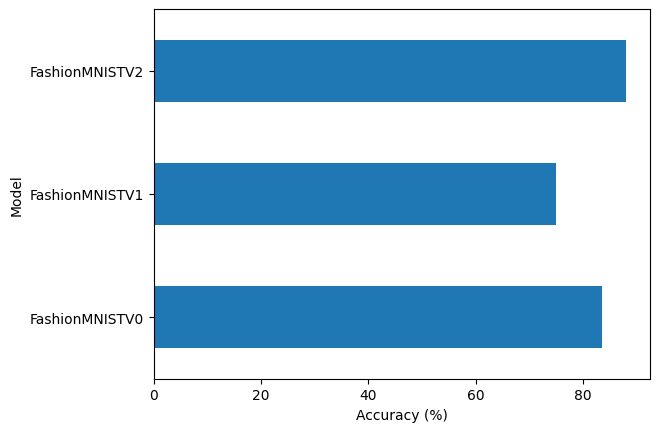

In [51]:
#visualize
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.show()

In [52]:
# make and evaluate randpm predictions with our best model
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample.to(device))
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [53]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

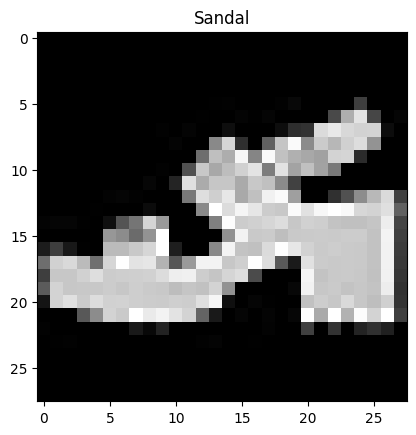

In [54]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(classes[test_labels[0]])

In [55]:
# Make predictions
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_probs[:2]

tensor([[3.9403e-08, 5.3008e-09, 1.9652e-08, 1.2967e-08, 4.4221e-09, 9.9995e-01,
         2.3846e-08, 1.4185e-06, 9.2211e-06, 4.0864e-05],
        [8.2510e-02, 7.1360e-01, 1.5430e-03, 4.5296e-02, 7.0746e-02, 2.4883e-05,
         8.6034e-02, 5.4444e-05, 7.3882e-05, 1.1673e-04]])

In [56]:
pred_classes = torch.argmax(pred_probs, dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

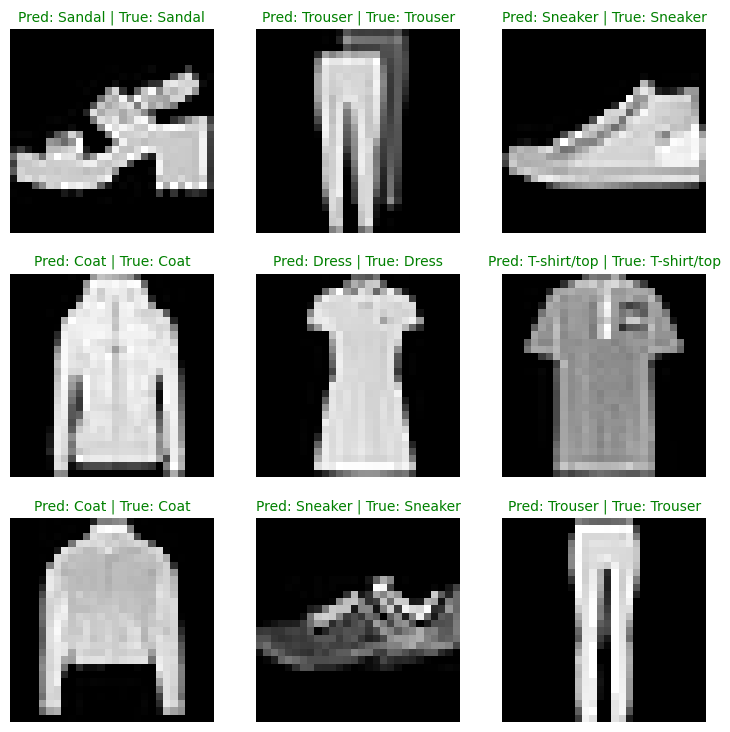

In [57]:
# plot predictions
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3
for i, image in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(image.squeeze(), cmap='gray')
  pred_label = classes[pred_classes[i]]
  true_label = classes[test_labels[i]]
  title_text = f"Pred: {pred_label} | True: {true_label}"
  if pred_label == true_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')
  plt.axis('off')
plt.show()

In [60]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [62]:
len(y_pred_tensor)

10000

# make a confusion matrix

In [64]:
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1]>=19)
except:
  !pip install -q torchmetrics mlxtend
  import torchmetrics, mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [67]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(classes), task="multiclass")
confmat_tensor = confmat(y_pred_tensor, test_data.targets)
confmat_tensor

tensor([[604,   5,  52,  58,  11,   1, 262,   0,   7,   0],
        [  9, 908,  11,  57,  10,   0,   4,   0,   1,   0],
        [  4,   3, 813,  12, 103,   0,  61,   0,   4,   0],
        [ 25,   9,  36, 843,  45,   0,  33,   0,   7,   2],
        [  2,   3, 151,  38, 701,   0, 100,   0,   5,   0],
        [  7,   3,   2,   6,   1, 838,   4,  58,  60,  21],
        [ 61,   7, 136,  61,  81,   0, 642,   0,  12,   0],
        [  1,   1,   0,   0,   0,  29,   0, 907,   7,  55],
        [ 10,   3,  45,  18,   7,   8,  27,   7, 873,   2],
        [  1,   0,   1,   1,   0,  19,   3,  87,  11, 877]])

Text(0.5, 1.0, 'Confusion Matrix')

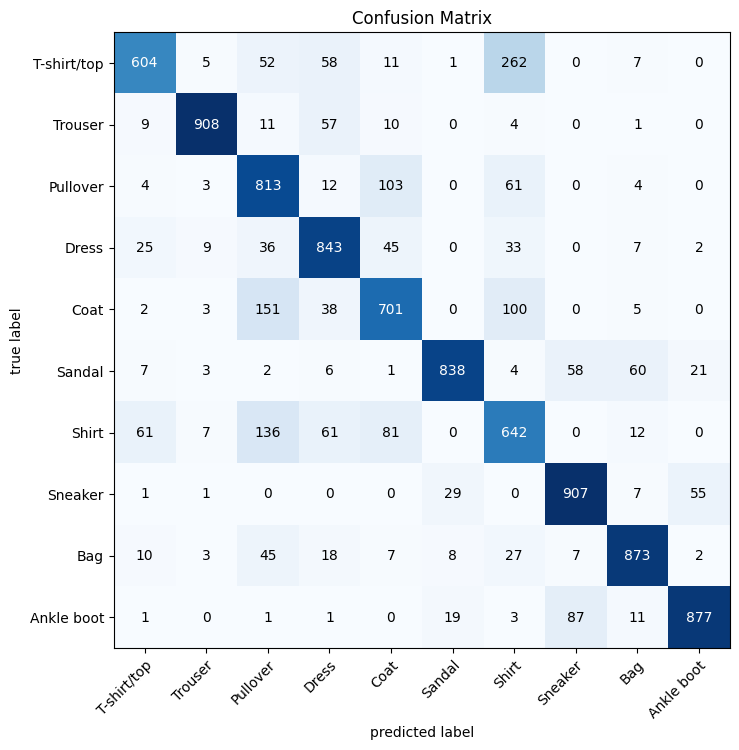

In [69]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), figsize=(8, 8), class_names=classes)
plt.title("Confusion Matrix")

# Saving model

In [70]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "fashion_mnist_cnn_model_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/fashion_mnist_cnn_model_v2.pth')

In [72]:
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [74]:
loaded_model_2 = FashionMNISTV2(input_shape=1, hidden_units=10, output_shape=len(classes))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

FashionMNISTV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [75]:
model_2_results

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3281460702419281,
 'model_acc': 87.97923322683707}

In [77]:
loaded_model_2_results = eval_model(model=loaded_model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.3281460702419281,
 'model_acc': 87.97923322683707}

In [80]:
# Check if the model results are close
torch.isclose(torch.tensor(model_2_results['model_loss']), torch.tensor(loaded_model_2_results['model_loss']), atol=1e-02)

tensor(True)